# Part 3 solution

Finally, in part 3, we will explore the affect of the absorbing boundary (sponge) layer. This should be explored using a single acquisition geometry. First, import your favorite FWI setup from either parts 1 or 2 into the notebook solution_part3.ipynb.

(a) Vary (increase and decrease) the width of the absorbing boundary layer and describe how it affects your wavefield at large times (the end time of the simulation or a little after will suffice). This explanation should contain a quantitative element.

(b) Explain how the width of the boundary layer affects the quality of your final FWI image. Explain how this may relate to your findings from part (a).

Note that, depending on your acquisition geometry, you may wish/need to increase your FWI iterations a little in (b).

This code defines a model with a fixed source and receiver geometry, then creates five different models with different sponge widths (10, 25, 50, 100, and 200), and computes the wavefield for each model. We can then plot the wavefield snapshots at a large time, such as 2 seconds after the source activation, for each simulation and compare the results. 

To quantify the effect of the absorbing layer width on the wavefield, we can calculate the L2 norm of the wavefield over the entire domain and analyze the misfit of the model.

In [2]:
# This cell contains the various imports we will need
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver

from devito import configuration
configuration['log-level'] = 'WARNING'

%matplotlib inline

#### Section1: Physical Problem

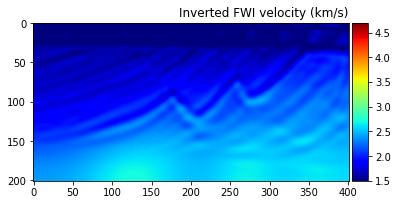

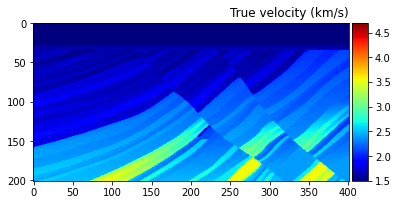

l2 norm of wavefield: 5669.2944


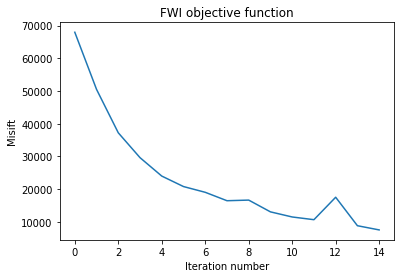

------------------end for nbl = 10----------------------


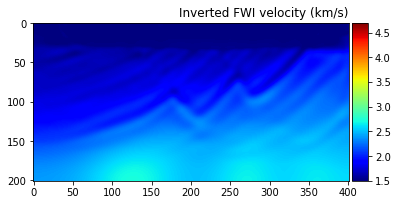

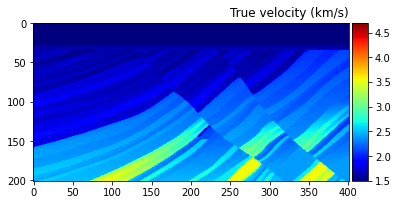

l2 norm of wavefield: 8033.0083


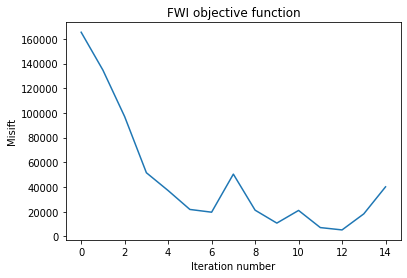

------------------end for nbl = 25----------------------


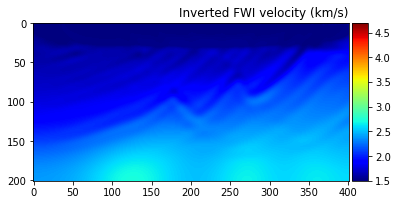

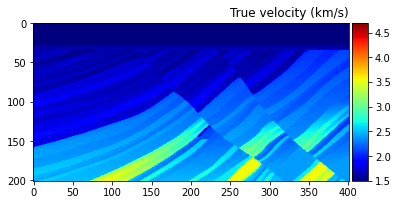

l2 norm of wavefield: 8049.277


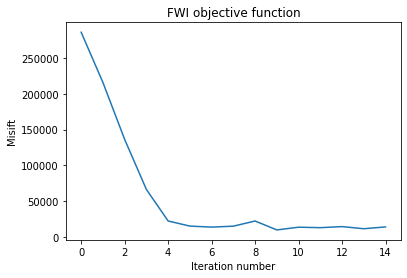

------------------end for nbl = 50----------------------


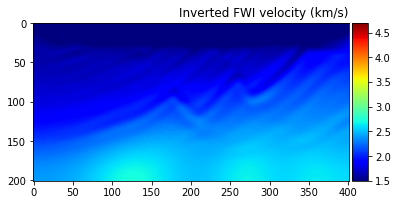

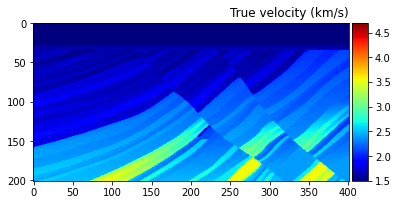

l2 norm of wavefield: 8687.591


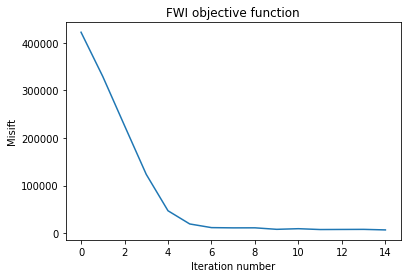

------------------end for nbl = 100----------------------


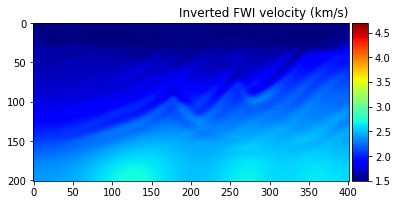

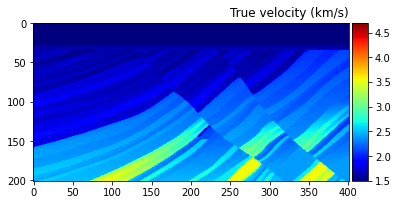

l2 norm of wavefield: 9882.1455


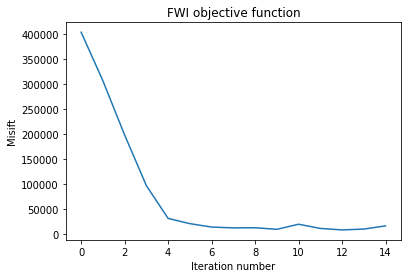

------------------end for nbl = 200----------------------


In [12]:
#Load 2D Marmousi velocity model, update the path of 'vp_marmousi_bi' as needed
v = np.fromfile('vp_marmousi_bi', dtype='float32', sep="")

#Velocity model dimension
shape = (1601, 401)
spacing = (10., 10.)
origin = (0., 0.)
nbl = np.array([10, 25, 50, 100, 200]) # Change the absorbing boundary layer
v = v.reshape(shape)

#Cut velocity model size from (1601,401) to (401,201)
v = v[600:-600, :201]

# Gaussian smoothing of the true velocity model
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)

for i in range (len(nbl)):
    #True Vp model
    model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl[i], grid=None,
                shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

    #Smooth/Initial Vp model
    model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl[i], grid=model.grid,
                shape=v.shape, origin=origin, spacing=spacing, bcs="damp")
    
    
    #set source number = 11, and receiver number = 101
    nsrc=11; nrcv=101;

    #set 11 source locations
    src_loc = np.empty((nsrc, 2), dtype=np.float32)
    src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nsrc)
    src_loc[:, 1] = 20.

    #set 101 receiver locations
    rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
    rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nrcv)
    rcv_loc[:, 1] = 20.

    t0 = 0.     # Shot records starts at 0.0
    tn = 2000.  # Shot records last 2.0 second (2000 ms)
    f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
    geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
    #Pick one source number
    isrc = 3
    geometry = AcquisitionGeometry(model, rcv_loc, src_loc[isrc-1:isrc,:],
                                t0, tn, f0=f0, src_type='Ricker')
    solver = AcousticWaveSolver(model, geometry, space_order=4)

    #Define forward modeling of one source
    def modeling_1src(vp_in):    
        # Create symbols to hold the data
        d_obs = Receiver(name='d_obs', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        # Generate modeled data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        # Compute modeled data and full forward wavefield u0 from smooth model
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        return d_obs, d_syn
    def compute_residual(residual, dobs, dsyn):
        if residual.grid.distributor.is_parallel:
            # Compute the residual via a difference operator for MPI
            diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                                dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
            Operator(diff_eq)()
        else:
            # A simple data difference is enough in serial
            residual.data[:] = dsyn.data[:] - dobs.data[:]
        return residual

    # Function to create FWI gradient kernel 
    def fwi_gradient(vp_in):    
        # Create symbols to hold the gradient, data residual and data
        grad = Function(name="grad", grid=model.grid)
        residual = Receiver(name='residual', grid=model.grid,
                            time_range=geometry.time_axis,
                            coordinates=geometry.rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
        objective = 0.
        for i in range(nsrc):
            # Update source location
            geometry.src_positions[0, :] = src_loc[i, :]
            # Generate true data "d_obs" from true model
            _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
            # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
            _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
            # Compute data "residual" from "d_obs" and "d_syn"
            compute_residual(residual, d_obs, d_syn)
            # Update objective function 
            objective += .5 * norm(residual)**2
            # Derive FWI gradient "grad" 
            solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
        return objective, grad

    # Function to perform the gradient decent update (with box constraints)
    from sympy import Min, Max
    def update_with_box(vp, alpha, direction, vmin=1.5, vmax=4.7):
        """
        Apply gradient update in-place to vp with box constraint
        """
        update = vp + alpha * direction
        update_eq = Eq(vp, Max(Min(update, vmax), vmin))
        Operator(update_eq)()
    
    # Run FWI with gradient descent
    fwi_iterations = 15
    objective = np.zeros((fwi_iterations, 1))
    for k in range(0, fwi_iterations):
        # Compute the current FWI objective function and gradient
        objective[k], direction = fwi_gradient(model0.vp)
        
        alpha = .05/mmax(direction) # We need to work out what values alpha can take

        # Update the velocity model in-place and enforce min/max value clips
        update_with_box(model0.vp, alpha, direction)
        from examples.seismic import plot_image

    # Plot inverted velocity model from FWI

    plt.title('Inverted FWI velocity (km/s)', loc='right')
    plot_image(model0.vp.data[nbl[i]:-nbl[i], nbl[i]:-nbl[i]], vmin=1.5, vmax=4.7, cmap="jet")

    # Plot True velocity model
    plt.title('True velocity (km/s)', loc='right')
    plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
    
    # plot objective function
    plt.plot(objective)
    plt.xlabel('Iteration number')
    plt.ylabel('Misift')
    plt.title('FWI objective function')
    _, u0, _ = solver.forward(vp=model0.vp, save=True, rec=Receiver(name='d_syn', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions))
    print('l2 norm of wavefield:',np.linalg.norm(u0.data))
    plt.show()
    print(f'------------------end for nbl = {nbl[i]}----------------------')


#### Explanation for a and b
With a narrow absorbing layer, we might observe some reflection of the outgoing waves at the boundary, especially for high-frequency components. The wavefield might also exhibit some artifacts or numerical noise due to the incomplete absorption. 

We can observe the images of misfit and quantitative value of u0 and make some conclusions and explanations. 


In general, a narrow boundary layer converges at a lower misfit and has a lower norm. Narrow ABL does not provide enough control of the boundary conditions and the waves are reflecting more strongly from the edges of the model. Therefore, this may result in higher resolution, a clearer boundary and the image is steeper **near the boundary**. Also, absorbing layer with smaller thickness can improve the computational efficiency and reduce the memory requirements, as fewer grid points need to be updated.

While a wide boundary layer converges at a higher misfit may reduce the accuracy (we can see form misfit graph) of the estimated model by over-damping the wavefield and removing important information. And this will result in a smoother wavefield(we can see the boundary will not be that clear) and lower resolution.The norm of the wavefield at large times  also increase.
